# Importing Libraries

In [41]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_score,
)
from random import randint
from statsmodels.stats.proportion import proportions_ztest

# Creating fake data to replicate

In [43]:
def generate_samples(samples1, samples2, random_state):
    # Define the desired number of samples for each class
    class_samples = [samples1, samples2]  # Adjust these numbers as needed

    # Calculate weights based on the desired number of samples
    class_weights = [num_samples / sum(class_samples) for num_samples in class_samples]


    # Generate a synthetic dataset with different numbers of samples for each class
    X, y = make_classification(
        n_samples=sum(class_samples),
        n_features=4,
        n_informative=4,
        n_redundant=0,
        n_classes=2,
        weights=class_weights,
        random_state=random_state,
    )

    # Create a Pandas DataFrame with the generated data
    columns = ["Feature_1", "Feature_2", "Feature_3", "Feature_4"]
    synthetic_df = pd.DataFrame(data=X, columns=columns)

    for column in synthetic_df:
        std = np.std(synthetic_df[column])
        mean = np.mean(synthetic_df[column])
        synthetic_df[column] = synthetic_df[column]-mean
        synthetic_df[column] = synthetic_df[column]/std


    synthetic_df["target"] = y

    # Display the first few rows of the synthetic dataset
    synthetic_array =synthetic_df.values
    return synthetic_array

# Train Test Split

In [44]:
data_dict = {}
random_integers = np.random.randn(10)

for _ in range(10):
    rand = randint(0, 1000)
    data_dict[rand] = {}
    data_dict[rand]["full"] = generate_samples(20000, 200, rand)
    while True: 

        (
            train_array,
            temp_data,
        ) = train_test_split(data_dict[rand]["full"], test_size=0.2, random_state=42)
        test_array, val_array = train_test_split(temp_data, test_size=0.5, random_state=42)

        train_avg = train_array[:, -1].mean()
        print(f"The value of train class is {train_avg}")
        val_avg = val_array[:, -1].mean()
        print(f"The value of val class is {val_avg}")
        test_avg = test_array[:, -1].mean()
        print(f"The value of test class is {test_avg}")

        if train_avg > 0.005 and val_avg > 0.005 and test_avg > 0.005:
            # Storing the sets in the data_dict
            data_dict[rand]["train"] = train_array
            data_dict[rand]["val"] = val_array
            data_dict[rand]["test"] = test_array
            break  # Exit the loop if condition is met

The value of train class is 0.01547029702970297
The value of val class is 0.012376237623762377
The value of test class is 0.013366336633663366
The value of train class is 0.014913366336633663
The value of val class is 0.013861386138613862
The value of test class is 0.018316831683168316
The value of train class is 0.015655940594059406
The value of val class is 0.013366336633663366
The value of test class is 0.015346534653465346
The value of train class is 0.015841584158415842
The value of val class is 0.01485148514851485
The value of test class is 0.01089108910891089
The value of train class is 0.013985148514851485
The value of val class is 0.01782178217821782
The value of test class is 0.01485148514851485
The value of train class is 0.013861386138613862
The value of val class is 0.013861386138613862
The value of test class is 0.01782178217821782
The value of train class is 0.014356435643564357
The value of val class is 0.01089108910891089
The value of test class is 0.018316831683168316

# Defining the sampling layer that is also the call

In [45]:
class Sampling(keras.layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Encoder

In [46]:
latent_dim = 4
encoder_inputs = Input(shape=(5), name="input_layer")

n_x = 75
x = Dense(n_x, activation="relu", name="h1")(encoder_inputs)

# Split x into two halves
half_size = n_x // 2
x3_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x3_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x3_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x3_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder

In [47]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x = 75

x = Dense(n_x, activation="relu", name="h4")(latent_inputs)

cont_decoder_outputs = Dense(4, activation="linear", name="cont_decoder_output")(x)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x)

decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 h4 (Dense)                     (None, 75)           375         ['input_2[0][0]']                
                                                                                                  
 cont_decoder_output (Dense)    (None, 4)            304         ['h4[0][0]']                     
                                                                                                  
 classification_output (Dense)  (None, 1)            76          ['h4[0][0]']                     
                                                                                            

# Custom VAE

In [48]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def call(self, inputs):
        # Define the forward pass
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[
                :, :4
            ]  # Assuming the first 4 columns are for continuous variables
            data_class = data[:, 4:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + 0.0001*kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {
            "loss": self.total_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[
            :, :4
        ]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 4:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)

        reconstruction_cont, reconstruction_class = self.decoder(z)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class = keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
            reconstruction_loss_cont + reconstruction_loss_class + 0.0001*kl_loss
        )


        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)


        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
        }

# Compile and Train

In [49]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [50]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore weights to the best model observed during training
)



In [51]:
hist_dict = {}
for key in data_dict:

    hist_dict[key] = vae.fit(
    data_dict[key]['train'],
    epochs=100,
    batch_size=32,
    validation_data=(data_dict[key]['val'], None),
    callbacks=early_stopping_callback,
    )

Epoch 1/100


505/505 [==============================] - 1s 2ms/step - loss: 0.9591 - val_loss: 0.1438
Epoch 2/100
505/505 [==============================] - 1s 1ms/step - loss: 0.1304 - val_loss: 0.0653
Epoch 3/100
505/505 [==============================] - 1s 1ms/step - loss: 0.0725 - val_loss: 0.0412
Epoch 4/100
505/505 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0178
Epoch 5/100
505/505 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0097
Epoch 6/100
505/505 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 7/100
505/505 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 8/100
505/505 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 9/100
505/505 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 10/100
505/505 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0038
E

In [52]:
# vae.save_weights("herre")

In [53]:
# vae1 = VAE(encoder, decoder)
# vae1.compile(optimizer=keras.optimizers.Adam())

In [54]:
# vae1.load_weights("herre")

In [55]:
# vae1.weights == vae.weights

In [56]:
# tf.saved_model.save(vae, "my_model_tf")
# loaded_model = tf.saved_model.load("my_model_tf")

# Generate data and visualy inspect

In [57]:
synthetic_array_dict = {}

for key in hist_dict:
    # from sampling
    size_of_test_data = len(data_dict[key]["test"])
    latent_vectors = np.random.normal(size=(size_of_test_data, latent_dim))

    generated_data_cont_sample, generated_data_class_sample= hist_dict[key].model.decoder.predict(
        latent_vectors
    )
    generated_data_class_transformed_sample = (generated_data_class_sample > 0.5).astype(int)
    print(sum(generated_data_class_transformed_sample))
    synthetic_array_dict[key] = {}

    synthetic_array_dict[key]["generated_data_cont_sample"] = generated_data_cont_sample
    synthetic_array_dict[key]["generated_data_class_sample"] = generated_data_class_transformed_sample
    synthetic_array_dict[key]["generated_data_class_sum_sample"] = sum(generated_data_class_transformed_sample)

    # from  data
    latent_vectors_from_data = hist_dict[key].model.encoder(data_dict[key]["test"])[
        2
    ]
    generated_data_cont_data, generated_data_class_data = hist_dict[key].model.decoder.predict(
        latent_vectors_from_data
    )
    generated_data_class_transformed_data = (generated_data_class_data > 0.5).astype(int)
    print(sum(generated_data_class_transformed_data))

    synthetic_array_dict[key]["generated_data_cont_data"] = generated_data_cont_data
    synthetic_array_dict[key][
        "generated_data_class_data"
    ] = generated_data_class_transformed_data
    synthetic_array_dict[key]["generated_data_class_sum_data"] = sum(
        generated_data_class_transformed_data
    )

64/64 [==============================] - 0s 992us/step
[409]
64/64 [==============================] - 0s 1ms/step
[27]
64/64 [==============================] - 0s 937us/step
[390]
64/64 [==============================] - 0s 936us/step
[37]
64/64 [==============================] - 0s 929us/step
[370]
64/64 [==============================] - 0s 2ms/step
[31]
64/64 [==============================] - 0s 1ms/step
[400]
64/64 [==============================] - 0s 1ms/step
[21]
64/64 [==============================] - 0s 1ms/step
[369]
64/64 [==============================] - 0s 1ms/step
[30]
64/64 [==============================] - 0s 1ms/step
[398]
64/64 [==============================] - 0s 975us/step
[36]
64/64 [==============================] - 0s 952us/step
[402]
64/64 [==============================] - 0s 921us/step
[37]
64/64 [==============================] - 0s 992us/step
[406]
64/64 [==============================] - 0s 945us/step
[27]
64/64 [==============================] - 0s 98

# Meassuring Utility

## Proportion Test to see if the Class Distribution is the same

In [58]:
count_test = 0
count_lenght = 0
for key in data_dict.keys():
    count_test += sum(data_dict[key]["test"][:, -1])
    count_lenght += len(data_dict[key]["test"])

count_test / count_lenght

0.015297029702970297

In [59]:
count_test_synth_data = 0
count_lenght_synth_data = 0
for key in synthetic_array_dict.keys():
    count_test_synth_data += sum(synthetic_array_dict[key]["generated_data_class_data"])
    count_lenght_synth_data += len(synthetic_array_dict[key]["generated_data_class_data"])

count_test_synth_data[0] / count_lenght_synth_data

0.015247524752475247

In [60]:
# z test for data from
z_stat, p_value = proportions_ztest(
    [count_test, count_test_synth_data[0]], [count_lenght, count_lenght_synth_data]
)

# Print the results
print("Z-statistic:", z_stat)
print("P-value:", p_value)

Z-statistic: 0.04056947014355358
P-value: 0.9676391234061272


In [61]:
count_test_synth_sample = 0
count_lenght_synth_sample = 0
for key in synthetic_array_dict.keys():
    count_test_synth_sample += sum(synthetic_array_dict[key]["generated_data_class_sample"])
    count_lenght_synth_sample += len(
        synthetic_array_dict[key]["generated_data_class_sample"]
    )

count_test_synth_sample[0] / count_lenght_synth_sample

0.19371287128712872

In [62]:
# z test for data from
z_stat, p_value = proportions_ztest(
    [count_test, count_test_synth_sample[0]], [count_lenght, count_lenght_synth_sample]
)

# Print the results
print("Z-statistic:", z_stat)
print("P-value:", p_value)

Z-statistic: -58.61301655143825
P-value: 0.0


# F-1 Calculation

In [63]:
forest_dict = {}

for key in data_dict:
    X = data_dict[key]["train"][:, :-1]
    y = data_dict[key]["train"][:, -1]
    random_forest = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42
    )
    random_forest.fit(X, y)
    forest_dict[key] = random_forest

In [64]:
def evaluate_model_performance_classification(model, X, y, name, key):
    # Predictions on training and testing data
    y_pred = model.predict(X)
    # Accuracy scores
    accuracy = accuracy_score(y, y_pred)
    # Recall scores
    recall = recall_score(y, y_pred)
    # precision
    precision = precision_score(y, y_pred)
    # F1 scores
    f1 = f1_score(y, y_pred)
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    # Create new row
    row = [name, key, accuracy, recall, precision, f1, conf_matrix]

    return row

## for the test data

In [65]:
results_list = []

for key in forest_dict:
    result = evaluate_model_performance_classification(
    forest_dict[key],
    data_dict[key]["train"][:, :-1],
    data_dict[key]["train"][:, -1],
    "test",
    key)
    results_list.append(result)

df_test_accuracy = pd.DataFrame(
    results_list, columns=["name", "key", "accuracy", "recall", "precision", "f1", "conf_matrix"]
)

In [66]:
df_test_accuracy[["accuracy", "recall", "f1", "precision"]].mean()

accuracy     0.990588
recall       0.371364
f1           0.531241
precision    1.000000
dtype: float64

## F1 Calculation for the data from the s-generation process

In [68]:
results_list = []

for key in forest_dict:
    result = evaluate_model_performance_classification(
        forest_dict[key],
        synthetic_array_dict[key]["generated_data_cont_sample"],
        synthetic_array_dict[key]["generated_data_class_sample"].flatten(),
        "synth",
        key,
    )
    results_list.append(result)

df_test_accuracy_synth_sample = pd.DataFrame(
    results_list,
    columns=["name", "key", "accuracy", "recall", "precision", "f1", "conf_matrix"],
)

In [69]:
df_test_accuracy_synth_sample[["accuracy", "recall", "f1", "precision"]].mean()


accuracy     0.703515
recall       0.188860
f1           0.153414
precision    0.200386
dtype: float64

## F1 Calculation for the data from the d-generation process

In [70]:
results_list = []

for key in forest_dict:
    result = evaluate_model_performance_classification(
        forest_dict[key],
        synthetic_array_dict[key]["generated_data_cont_data"],
        synthetic_array_dict[key]["generated_data_class_data"].flatten(),
        "synth",
        key,
    )
    results_list.append(result)

df_test_accuracy_synth_data = pd.DataFrame(
    results_list,
    columns=["name", "key", "accuracy", "recall", "precision", "f1", "conf_matrix"],
)

In [71]:
df_test_accuracy_synth_data

,name,key,accuracy,recall,precision,f1,conf_matrix
0,synth,60,0.988119,0.111111,1.000000,0.200000,"[[1993, 0], [24, 3]]"
1,synth,860,0.984653,0.162162,1.000000,0.279070,"[[1983, 0], [31, 6]]"
2,synth,137,0.987129,0.161290,1.000000,0.277778,"[[1989, 0], [26, 5]]"
3,synth,594,0.992574,0.285714,1.000000,0.444444,"[[1999, 0], [15, 6]]"
4,synth,467,0.987129,0.133333,1.000000,0.235294,"[[1990, 0], [26, 4]]"
5,synth,754,0.988119,0.333333,1.000000,0.500000,"[[1984, 0], [24, 12]]"
6,synth,127,0.993564,0.702703,0.928571,0.800000,"[[1981, 2], [11, 26]]"
7,synth,379,0.990594,0.296296,1.000000,0.457143,"[[1993, 0], [19, 8]]"
8,synth,363,0.985644,0.200000,0.875000,0.325581,"[[1984, 1], [28, 7]]"
9,synth,513,0.988119,0.111111,1.000000,0.200000,"[[1993, 0], [24, 3]]"


In [72]:
df_test_accuracy_synth_data[["accuracy", "recall", "f1", "precision"]].mean()

accuracy     0.988564
recall       0.249705
f1           0.371931
precision    0.980357
dtype: float64

In [74]:
random_number = 127

df_test = pd.DataFrame(
    data_dict[random_number]["test"],

    columns=["Feature_1", "Feature_2", "Feature_3", "Feature_4", "Class"],
)
df_test_synth0 = pd.DataFrame(
    synthetic_array_dict[random_number]["generated_data_cont_data"],
    columns=["Feature_1", "Feature_2", "Feature_3", "Feature_4"],
)

df_test_synth1 = pd.DataFrame(
    synthetic_array_dict[random_number]["generated_data_class_data"].flatten(),
    columns=["Class"],
)

df_test_synth = pd.concat([df_test_synth0, df_test_synth1], axis=1)

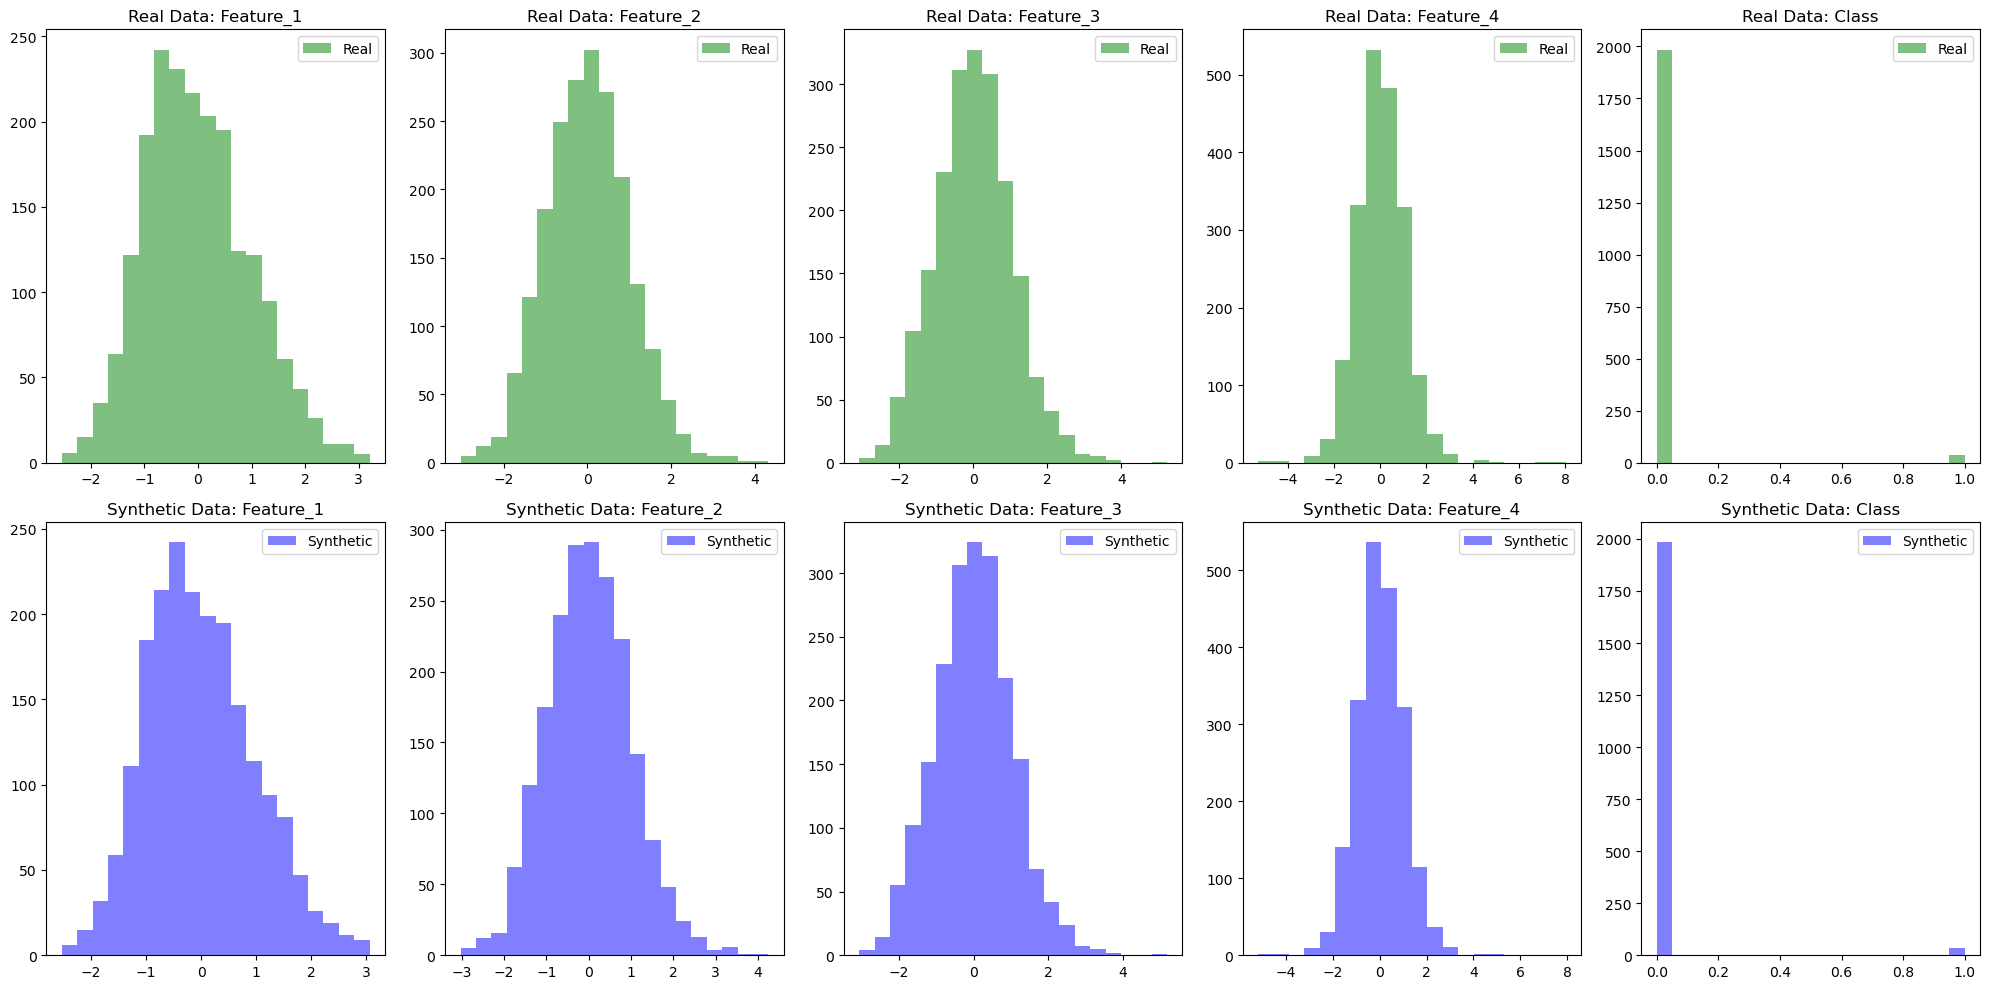

In [75]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=len(df_test.columns), figsize=(20, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each feature
for i, feature in enumerate(df_test.columns):
    # Plot real data histogram
    axes[i].hist(df_test[feature], bins=20, alpha=0.5, color="g", label="Real")
    axes[i].set_title(f"Real Data: {feature}")
    axes[i].legend()

    # Plot synthetic data histogram
    axes[i + len(df_test.columns)].hist(
        df_test_synth[feature], bins=20, alpha=0.5, color="b", label="Synthetic"
    )
    axes[i + len(df_test.columns)].set_title(f"Synthetic Data: {feature}")
    axes[i + len(df_test.columns)].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(df_test.describe())
print("\nSummary statistics for the synthetic data:")
print(df_test_synth.describe())

Summary statistics for the real data:
         Feature_1    Feature_2    Feature_3    Feature_4        Class
count  2020.000000  2020.000000  2020.000000  2020.000000  2020.000000
mean     -0.014373    -0.017704     0.031935     0.017570     0.019307
std       0.975838     0.999329     0.992630     0.985037     0.137636
min      -5.384197    -3.574805    -2.865096    -3.816732     0.000000
25%      -0.650660    -0.699436    -0.718268    -0.584929     0.000000
50%      -0.013862    -0.012224    -0.171467     0.195089     0.000000
75%       0.643747     0.639760     0.710129     0.729197     0.000000
max       2.982748     4.298928     3.511219     2.247319     1.000000

Summary statistics for the synthetic data:
         Feature_1    Feature_2    Feature_3    Feature_4        Class
count  2020.000000  2020.000000  2020.000000  2020.000000  2020.000000
mean      0.206090     0.039453    -0.328749    -0.630091     0.018812
std       0.720021     0.960158     0.997371     0.993104     0.13